<a href="https://colab.research.google.com/github/g-nyuk/Demand-Side_Fluctuation/blob/Constant-Conditions/(Constant_Demand)Demand_Side_Fluctuation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from scipy.integrate import quad
from sklearn.preprocessing import MinMaxScaler

In [2]:
#INITIAL CONDITION - FIRM
INITIAL_CAPITAL = 100
INITIAL_PATHNUM = 1

#COMPETION CONDITON
COMPENSATION = 40
UNIT_EXPENDITURE = 10
TIME_DURATION = 300

In [3]:
class BetaDist:
    def __init__(self, alpha, beta):
        self.dist = scipy.stats.beta(alpha, beta)

    def plot_pdf(self):
        x = np.linspace(0, 1, 1000)
        y = self.dist.pdf(x)
        plt.plot(x, y)
        plt.title('Beta Distribution')
        plt.xlabel('x')
        plt.ylabel('pdf(x)')
        plt.grid(True)
        plt.show()

    def sample(self, n):
        return self.dist.rvs(n)

    def plot_prob(self, num_intervals):
        interval_probs = []
        interval_ranges = np.linspace(0, 1, num_intervals+1)

        for i in range(num_intervals):
            x_low = interval_ranges[i]
            x_high = interval_ranges[i+1]
            prob, _ = quad(self.dist.pdf, x_low, x_high)
            interval_probs.append(prob)

        plt.bar(range(num_intervals), interval_probs, tick_label=[f'{interval_ranges[i]:.1f}-{interval_ranges[i+1]:.1f}' for i in range(num_intervals)])
        plt.title('Interval Probabilities')
        plt.xlabel('Interval')
        plt.ylabel('Probability')
        plt.grid(True)
        plt.show()

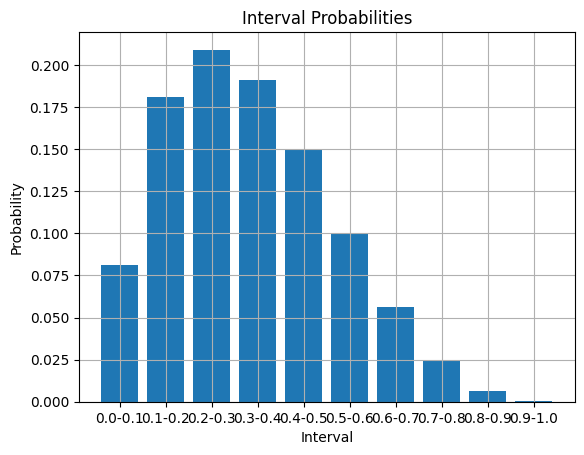

In [24]:
b = BetaDist(2,4)
b.plot_prob(10)

In [4]:
class Firm:
    def __init__(self, name, capital=INITIAL_CAPITAL, numPath=INITIAL_PATHNUM, unit_expenditure=UNIT_EXPENDITURE):
        self.name = name
        self.capital = capital
        self.numPath = numPath
        self.unit_expenditure = unit_expenditure
        self.beta = BetaDist(2,4)
        self.quality = 0
        self.bankrupt = False

    def invest(self):
        if self.capital < self.unit_expenditure * self.numPath:
            self.bankrupt = True
            self.quality = 0
            return (self.name, 0)

        if self.capital // 100 != self.numPath  and self.capital // 100 != 0 :
            self.numPath = self.capital // 100

        elif self.capital // 100 == 0 :
            self.numPath = 1

        self.capital -= self.unit_expenditure * self.numPath

        self.quality = max(self.beta.sample(self.numPath))

        return (self.name, self.quality)

In [9]:
class FirmCompetition:
    def __init__(self, firms, alpha=2, beta=4, compensation = COMPENSATION):
        self.firms = firms
        self.dist = BetaDist(alpha, beta)
        self.compensation = compensation

    def compete(self):
        quality = 0
        winner = None
        for firm in self.firms:
            invest_result = firm.invest()
            if invest_result is not None:
                _, value = invest_result
                if value > quality:
                    quality = value
                    winner = invest_result
        if winner is not None:
            winner_name, _ = winner
            for firm in self.firms:
                if firm.name == winner_name:
                    firm.capital += self.compensation
        return winner

In [10]:
def single_simulation(num_firms = 2):
    firms = [Firm(f'Firm {chr(65+i)}') for i in range(num_firms)]
    competition = FirmCompetition(firms)
    data = []

    for timestep in range(TIME_DURATION):
        winner = competition.compete()
        for firm in firms:
            if firm.bankrupt:
                continue
            data.append({
                'timestep': timestep,
                'firm': firm.name,
                'capital': firm.capital,
                'numPath': firm.numPath,
                'quality': firm.quality,
                'winner': winner[0] if winner else None,
            })

    df = pd.DataFrame(data)
    df = df.astype({'timestep': int, 'capital': np.float64, 'numPath': int})

    bankrupt_firms = len([firm for firm in firms if firm.bankrupt])

    return df

In [13]:
df = single_simulation()

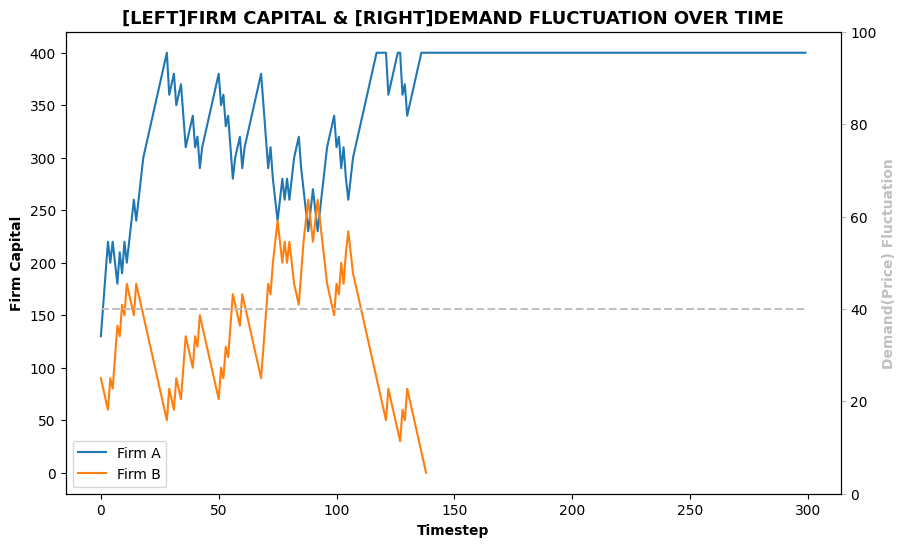

In [14]:
firm_a = df[df['firm'] == 'Firm A']
firm_b = df[df['firm'] == 'Firm B']

fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot()

ax1.plot(firm_a['timestep'], firm_a['capital'], label='Firm A')
ax1.plot(firm_b['timestep'], firm_b['capital'], label='Firm B')
ax1.set_xlabel('Timestep', fontweight = 'bold', fontsize = 10)
ax1.set_ylabel('Firm Capital', fontweight = 'bold', fontsize = 10)
ax1.tick_params(axis='y')
ax1.legend()

ax2 = ax1.twinx()
ax2.plot(firm_a['timestep'], [COMPENSATION for _ in range(len(firm_a['timestep']))], '--', color = 'silver')
ax2.set_ylabel('Demand(Price) Fluctuation', fontweight = 'bold', color = 'silver', fontsize = 10)
ax2.set_ylim(0, 100)
ax2.tick_params(axis='y', color = 'silver')


plt.title('[LEFT]FIRM CAPITAL & [RIGHT]DEMAND FLUCTUATION OVER TIME', fontweight = 'heavy', fontsize = 13)
plt.show()

In [15]:
def simulation_statistics(iterations, alpha=2, beta=4, num_firms = 2):
    wta = 0
    parrallel = 0

    for _ in range(iterations):
        firms = [Firm(f'Firm {chr(65+i)}') for i in range(num_firms)]
        competition = FirmCompetition(firms, alpha, beta)

        for timestep in range(TIME_DURATION):
            competition.compete()
            bankrupt_firms = [firm for firm in firms if firm.bankrupt]
            if len(bankrupt_firms) > num_firms - 1:
                break

        surviving_firms = sum(1 for firm in firms if not firm.bankrupt)
        if surviving_firms == 1:
            wta += 1
        elif surviving_firms == num_firms:
            parrallel += 1

    wta_prob = wta / iterations
    parrallel_prob = parrallel / iterations

    return wta_prob, parrallel_prob

In [554]:
wta_prob, parrallel_prob = simulation_statistics(1000)
print(f"Probability of only one firm surviving: {wta_prob}")
print(f"Probability of both firms surviving: {parrallel_prob}")

Probability of only one firm surviving: 0.91
Probability of both firms surviving: 0.09


In [17]:
alpha_values = np.arange(2, 11)
beta_values = np.arange(2, 11)
wta_probs = np.zeros((len(alpha_values), len(beta_values)))

for i, alpha in enumerate(alpha_values):
    print(f"a = {alpha:2} : ", end = "")
    for j, beta in enumerate(beta_values):
        print(f"🀰",end = "")
        wta_prob, _ = simulation_statistics(1000, alpha, beta)
        wta_probs[i, j] = wta_prob
    print("")

a =  2 : 🀰🀰🀰🀰🀰🀰🀰🀰🀰
a =  3 : 🀰🀰🀰🀰🀰🀰🀰🀰🀰
a =  4 : 🀰🀰🀰🀰🀰🀰🀰🀰🀰
a =  5 : 🀰🀰🀰🀰🀰🀰🀰🀰🀰
a =  6 : 🀰🀰🀰🀰🀰🀰🀰🀰🀰
a =  7 : 🀰🀰🀰🀰🀰🀰🀰🀰🀰
a =  8 : 🀰🀰🀰🀰🀰🀰🀰🀰🀰
a =  9 : 🀰🀰🀰🀰🀰🀰🀰🀰🀰
a = 10 : 🀰🀰🀰🀰🀰🀰🀰🀰🀰


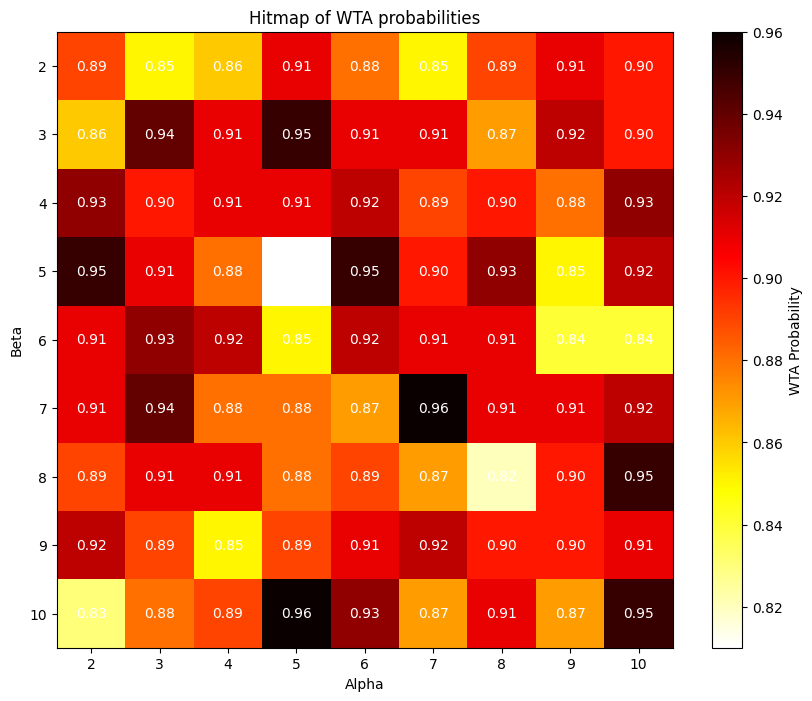

In [19]:
plt.figure(figsize=(10, 8))
plt.imshow(wta_probs, cmap='hot_r', interpolation='nearest')
plt.colorbar(label='WTA Probability')
plt.xticks(ticks=np.arange(len(alpha_values)), labels=alpha_values)
plt.yticks(ticks=np.arange(len(beta_values)), labels=beta_values)
plt.xlabel('Alpha')
plt.ylabel('Beta')

for i in range(len(alpha_values)):
    for j in range(len(beta_values)):
        plt.text(j, i, f'{wta_probs[i, j]:.2f}', ha='center', va='center', color='white')

plt.title('Hitmap of WTA probabilities')
plt.show()